In [1]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import GridSpec
import matplotlib.gridspec as gridspec
import numpy as np
import glob
import pandas as pd
import math

import skimage
import skimage.io
from skimage.morphology import disk
from skimage.filters import rank

import seaborn as sns

plt.style.use('styleNB.mplstyle')

import cv2
import numpy as np
from scipy.ndimage import gaussian_filter, binary_dilation, binary_erosion
from skimage.measure import regionprops, label
from aicsimageio import AICSImage
from aicsimageio.writers import OmeTiffWriter
import scipy as sp


######################################
######################################
# Functions for segmentation
######################################
######################################

from scipy.ndimage import gaussian_filter, binary_closing, binary_opening


def generate_gradient_mask(image, threshold=50):
    """
    Generates a binary mask based on the gradient magnitude.

    Parameters:
        image (np.ndarray): The input 2D image.
        threshold (int): The threshold value for gradient magnitude.

    Returns:
        np.ndarray: The binary mask.
    """
    # Convert image to grayscale
    image = image.astype(np.float32)

    # Compute gradients using Sobel operator
    grad_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
    grad_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)
    gradient_magnitude = np.sqrt(grad_x**2 + grad_y**2)

    # Threshold the gradient magnitude to generate the mask
    mask = (gradient_magnitude > threshold).astype(np.uint8)

    return mask


def smooth_mask_edges_morphological(mask, sigma=1.0, threshold=0.5, closing_iterations=1, opening_iterations=1):
    """
    Smooth the edges of a binary mask using Gaussian blurring followed by morphological closing and opening.
    
    Parameters:
    mask (np.ndarray): The input binary mask image.
    sigma (float): The standard deviation for Gaussian kernel. Higher values result in more smoothing.
    threshold (float): The threshold to convert the smoothed mask back to binary.
    closing_iterations (int): The number of iterations for the closing operation.
    opening_iterations (int): The number of iterations for the opening operation.
    
    Returns:
    np.ndarray: The smoothed binary mask image.
    """
    # Ensure the mask is binary (0 or 1)
    binary_mask = mask.astype(np.float32)
    
    # Apply Gaussian filter for smoothing
    smoothed_mask = gaussian_filter(binary_mask, sigma=sigma)
    
    # Normalize the smoothed mask to the range [0, 1]
    smoothed_mask = (smoothed_mask - smoothed_mask.min()) / (smoothed_mask.max() - smoothed_mask.min())
    
    # Apply threshold to convert back to binary mask
    smoothed_binary_mask = (smoothed_mask > threshold).astype(np.int32)
    
    # Apply morphological closing to smooth the edges
    closed_mask = binary_closing(smoothed_binary_mask, iterations=closing_iterations)
    
    # Apply morphological opening to further smooth the edges
    opened_mask = binary_opening(closed_mask, iterations=opening_iterations)
    
    return opened_mask.astype(np.int32)

######################################
######################################
# Functions for quantifying edge intensity
######################################
######################################

import numpy as np
from shapely.geometry import LineString
from shapely.ops import unary_union
from skimage import measure

def mask_to_polygon(mask):
    """Converts a pixel mask into a line that outlines the edge."""
    # Find contours in the mask
    contours = measure.find_contours(mask, 0.5)

    # Select the longest contour
    contour = max(contours, key=len)

    # Convert the contour points to integer coordinates
    contour = np.round(contour).astype(int)

    # Filter out duplicate points from the contour
    unique_contour = []
    for point in contour:
        if len(unique_contour) == 0 or not np.array_equal(unique_contour[-1], point):
            unique_contour.append(point)

    return unique_contour

def polygon_to_line(mask):
    """Converts a pixel mask into an array of position values that outlines the edge."""
    # Convert mask to polygon
    line = mask_to_polygon(mask)
    line = LineString(line)

    # Find the centroid of the polygon
    centroid = line.centroid

    # Find the southmost point relative to the centroid (maximum y-coordinate)
    max_y = max(line.coords, key=lambda point: point[1])

    # Rotate the line so that the southmost point is the first point
    coords = list(line.coords)
    max_y_index = coords.index(max_y)
    rotated_coords = coords[max_y_index:] + coords[:max_y_index]

    line = LineString(rotated_coords)

    # Redraw line with equally spaced coords
    n = 301
    distances = np.linspace(0, line.length, n)
    points = [line.interpolate(distance) for distance in distances]
    new_line = LineString(points)
   
    return new_line


def cell_contour_intensity_max2(new_line, im, cd_length = 15):
    # placeholder for intensity values
    vals = []
    y = []
    x = []
    xy = []

    # for each position in the edge line ('new_line'),
    for j in np.arange(300):
        # position j
        a = list(new_line.coords)[j] 
        # position j+1
        b = list(new_line.coords)[j + 1]
        # line from a to b
        ab = LineString([a, b])
        
        y = np.append(y, ab.coords[0][0])
        x = np.append(x, ab.coords[0][1])
        xy = np.append(xy, ab.coords[0][::-1])
        
        # define offset that is perpendicular to ab
        left = ab.parallel_offset(cd_length * 0.5, 'left')
        right = ab.parallel_offset(cd_length * 0.5, 'right')
        c = left.boundary.bounds[-2:]
        d = right.boundary.bounds[:2]  

        # line that runs perpendicular to edge between ab
        cd = LineString([c, d])

        # Generate line mask along cd
        n = 100
        distances_ = np.linspace(0, cd.length, n)
        points_ = [cd.interpolate(distance) for distance in distances_]
        mask = np.zeros(im.shape)
        for k in np.arange(len(points_)):
            mask[int(list(points_[k].coords)[0][1]), int(list(points_[k].coords)[0][0])] = 1

        # Background subtraction
        #im = im - np.mean(im[:10, :10])
        
        # quantify intensity by multipying fluorescence image with line 'mask' - ABSOLUTE MAX
        # Element-wise multiply mask and image
        multiplied = np.multiply(mask, im)

        # Find the index of the maximum absolute value
        max_abs_index = np.argmax(np.abs(multiplied))

        # Get the original value with its sign
        max_value_with_sign = multiplied.flatten()[max_abs_index]

        vals = np.append(vals, max_value_with_sign)
    
    return vals, x, y, xy



In [2]:
# Some useful values

ip = 210.0/995.0 #995 pixels / 210 um interpixel distance


# Segment

In [3]:
files = glob.glob('../../data/microscopy/Amy/20240213_GalvGFP_1.2mA_10_Single cell example-Cell14/*.tif')
files

['../../data/microscopy/Amy/20240213_GalvGFP_1.2mA_10_Single cell example-Cell14/cell14_Velocity_Visualisation_C2.tif',
 '../../data/microscopy/Amy/20240213_GalvGFP_1.2mA_10_Single cell example-Cell14/cell14_20240213_GalvGFP_1.2mA_10_MMStack_Pos0.ome.tif - C=0.tif - C=0.tif',
 '../../data/microscopy/Amy/20240213_GalvGFP_1.2mA_10_Single cell example-Cell14/cell14_Velocity_Visualisation_C1.tif',
 '../../data/microscopy/Amy/20240213_GalvGFP_1.2mA_10_Single cell example-Cell14/cell14_Result of Result of 20240213_GalvGFP_1.2mA_10_MMStack_Pos0.ome.tif - C=1.tif - C=0.tif - C=0.tif',
 '../../data/microscopy/Amy/20240213_GalvGFP_1.2mA_10_Single cell example-Cell14/mask_t0.tif',
 '../../data/microscopy/Amy/20240213_GalvGFP_1.2mA_10_Single cell example-Cell14/cell14_Velocity_Visualisation.tif',
 '../../data/microscopy/Amy/20240213_GalvGFP_1.2mA_10_Single cell example-Cell14/cell14_signal_preProcess_20240213_GalvGFP_1.2mA_10_MMStack_Pos0.ome.tif - C=0.tif - C=0.tif',
 '../../data/microscopy/Amy/2

In [8]:
# load image 
f = files[0]
img = AICSImage(f)  
im = img.get_image_data("TCZYX") 
im_ph = im[:,0,0,:,:] # select phase image

# placeholder for segmentation masks
im_mask = np.zeros_like(im_ph)

# perform segmentation
for i in np.arange(im_ph.shape[0]): #[:1]:
    # gradient of phase image, with threshold cutoff to identify cell boundaries 
    im_temp = generate_gradient_mask(im_ph[i,:,:], threshold=600)

    # dilate to connect any discontinuities and fill holes
    bw = sp.ndimage.binary_dilation(im_temp, structure = np.ones((1,1)), iterations=1)
    bw = sp.ndimage.binary_fill_holes(bw)

    # erode a bit to shrink masks
    bw_mask = sp.ndimage.binary_erosion(bw, structure = np.ones((3,3)), iterations=2)

    #im_mask[i,:,:] = smooth_mask_edges(bw_mask, sigma=0.1)
    im_mask[i,:,:] = smooth_mask_edges_morphological(bw_mask, 
                                                     sigma=3.0, 
                                                     threshold=0.5, 
                                                     closing_iterations=2, 
                                                     opening_iterations=2)

/var/folders/hs/8f67z23n6g9g9g4y03yhrn_c0000gn/T/ipykernel_2376/2204794828.py:82: RuntimeWarning: invalid value encountered in true_divide
  smoothed_mask = (smoothed_mask - smoothed_mask.min()) / (smoothed_mask.max() - smoothed_mask.min())


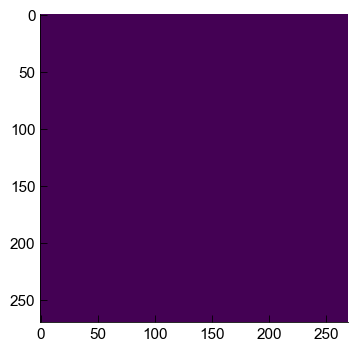

In [9]:
plt.imshow(im_mask[-1])

In [6]:
df_cells = pd.DataFrame()

for t in np.arange(img.shape[0]):
    im_labeled, n_labels = skimage.measure.label(im_mask[t,:,:], background=0, return_num=True)
    im_props = skimage.measure.regionprops(im_labeled)

    ind = np.argmax([prop.area for prop in im_props])
    centroids = [prop.centroid for prop in im_props]

    datalist = {'cell' : ind+1,
                'centroid' : centroids[ind],
               'frame' : t}

    df_cells = pd.concat([df_cells, pd.DataFrame([datalist])], ignore_index=True)
            
        
df_cells

ValueError: attempt to get argmax of an empty sequence

In [180]:
df_cells[df_cells.frame == 80]

,cell,centroid,frame
80,4,"(96.10630816959669, 55.483143743536715)",80


In [211]:
frame = 0
cell_val = df_cells[df_cells.frame == frame].cell.values[0]
#######
# 1. Identify cell in mask 
#######
im_labeled, n_labels = skimage.measure.label(im_mask[frame,:,:], background=0, return_num=True)

df_cells_ = df_cells[df_cells.frame == frame]
ind = im_labeled[np.floor(df_cells_[df_cells_.cell == cell_val].centroid.values[0]).astype('int')[0],
          np.floor(df_cells_[df_cells_.cell == cell_val].centroid.values[0]).astype('int')[1]]

# generate mask file with only cell of interest
im_labeled[im_labeled != ind] = 0
im_labeled[im_labeled>0] = 1
im_m = im_labeled

im_m_dilate = binary_dilation(im_m, structure = np.ones((3,3)), iterations = 5)


In [243]:
f

[]

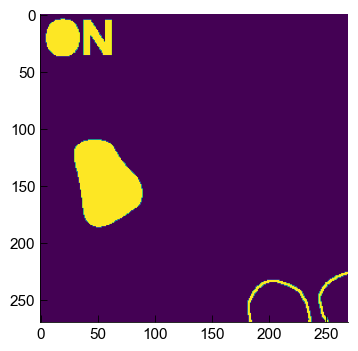

In [398]:
plt.imshow(im_vel_mask[60])

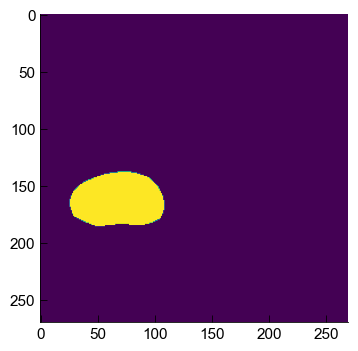

In [527]:
f = glob.glob('../../data/microscopy/Amy/20240213_GalvGFP_1.2mA_10_Single cell example-Cell14/*Vel*C1.tif')
# load image 
im_c1 = AICSImage(f[0])  
im_c1 = im_c1.get_image_data("ZYX") 

f = glob.glob('../../data/microscopy/Amy/20240213_GalvGFP_1.2mA_10_Single cell example-Cell14/*Vel*C2.tif')
# load image 
im_c2 = AICSImage(f[0])  
im_c2 = im_c2.get_image_data("ZYX") 


im_vel = im_c1 + im_c2

# # # placeholder for segmentation masks
im_vel_mask = np.zeros_like(im_vel)

# perform segmentation
for t in np.arange(im_vel.shape[0]): #[:1]:
    # gradient of phase image, with threshold cutoff to identify cell boundaries 
    im_temp = im_vel[t]
    im_temp[im_temp>0] = 1
    im_temp = binary_dilation(im_temp, structure = np.ones((2,2)), iterations=1)
    
    im_vel_mask[t] = sp.ndimage.binary_fill_holes(im_temp)
    
    
########## get rid of 'ON'

im_vel_mask_temp = np.zeros_like(im_vel_mask)
im_vel_mask_temp = im_vel_mask_temp[:,:,:]



for i in np.arange(im_vel_mask.shape[0]):
    im_m_temp = im_vel_mask[i,:,:]
    im_m_temp[:50,:70] = 0
    
    im_labeled, n_labels = skimage.measure.label(im_vel_mask[i,:,:], background=0, return_num=True)
    im_labeled[im_labeled != 1] = 0
    im_vel_mask_temp[i] = im_labeled
    
plt.imshow(im_vel_mask_temp[0])

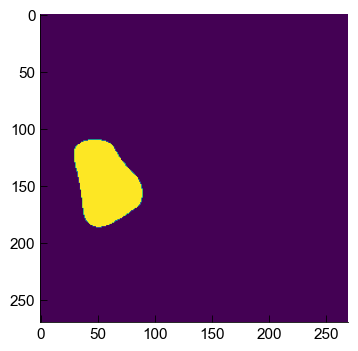

In [528]:
plt.imshow(im_vel_mask_temp[60])

In [463]:
im_GFP.shape

(270, 270)

In [426]:
# OmeTiffWriter.save(im_corr, f_dir + filename, dim_order="TCYX")
f_save = '../../data/microscopy/Amy/20240213_GalvGFP_1.2mA_10_Single cell example-Cell14/mask_t0.tif'
OmeTiffWriter.save(im_vel_mask_temp[0], f_save, dim_order="YX")

/Users/nathanb/opt/anaconda3/lib/python3.9/site-packages/ome_types/_convenience.py:112: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, validate=validate)


In [439]:
type(im_vel_mask_temp[0])

numpy.ndarray

(-0.5, 269.5, 269.5, -0.5)

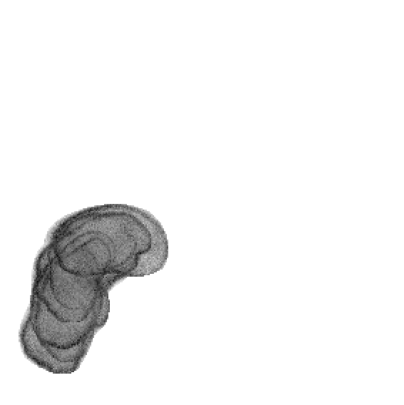

In [557]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import scipy

def merge_arrays(A, B):
    # Ensure both arrays are numpy arrays
    A = np.array(A)
    B = np.array(B)
    
    # Check if the shapes of A and B are the same
    if A.shape != B.shape:
        raise ValueError("Both arrays must have the same shape")
    
    # Initialize the result array with zeros
    #result = np.zeros_like(A)
    # Initialize the result array with zeros
    result = 255*np.ones_like(A)
    
    # Iterate over each element in the arrays
    for i in range(A.shape[0]):
        for j in range(A.shape[1]):
            if A[i, j] != 255 or B[i, j] != 255:
                result[i, j] = min(A[i, j], B[i, j])
                
    
    return result


def mask_array(A, B):
    #A is real image, B is mask
    # Ensure both arrays are numpy arrays
    A = np.array(A)
    B = np.array(B)
    
    # Check if the shapes of A and B are the same
    if A.shape != B.shape:
        raise ValueError("Both arrays must have the same shape")
    
    # Initialize the result array with zeros
    #result = np.zeros_like(A)
    # Initialize the result array with zeros
    result = A
    
    # Iterate over each element in the arrays
    for i in range(A.shape[0]):
        for j in range(A.shape[1]):
            if B[i, j] == 0:
                result[i, j] = 255
                
    return result




f = glob.glob('../../data/microscopy/Amy/20240213_GalvGFP_1.2mA_10_Single cell example-Cell14/GFP_inverted_jpg/*.jpg')
f=np.sort(f)

# frames = np.arange(60,120,10)
frames = np.arange(0,60,10)
# frames = np.arange(110)

# masked_image = np.zeros_like(im_vel_mask_temp[0])
masked_image = 255*np.ones_like(im_vel_mask_temp[0])

fig, ax = plt.subplots(1, 1, figsize=(5, 5))

for i in frames:
    im_GFP = AICSImage(f[i])  
    im_GFP = im_GFP.get_image_data("YX") 
    im_GFP = im_GFP[:,:]
    im_GFP = im_GFP.astype(np.uint8)
    #im_GFP = 255 - im_GFP

    binary_mask = im_vel_mask_temp[i] 

    binary_mask = scipy.ndimage.binary_dilation(binary_mask, structure=np.ones((3,3)), iterations = 2)
    binary_mask = binary_mask.astype(np.uint8)

    #inverted_mask = cv2.bitwise_not(binary_mask)
    # Apply the mask to the image
    masked_image_ = mask_array(im_GFP,binary_mask )
    #masked_image_ = cv2.bitwise_and(im_GFP, im_GFP, mask=binary_mask)
    
    masked_image = merge_arrays(masked_image, masked_image_)


    
# masked_image[masked_image==0] = 255 
# masked_image = 255- masked_image
ax.imshow(masked_image, cmap='gray')
    
ax.axis('off')

   

(-0.5, 269.5, 269.5, -0.5)

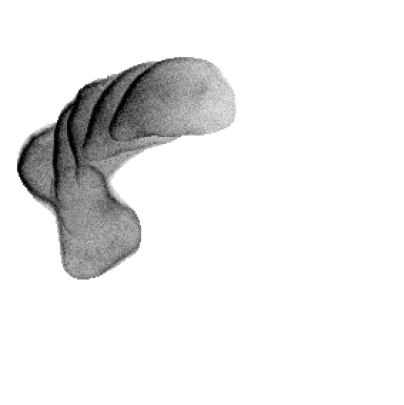

In [559]:
f = glob.glob('../../data/microscopy/Amy/20240213_GalvGFP_1.2mA_10_Single cell example-Cell14/GFP_inverted_jpg/*.jpg')
f=np.sort(f)

frames = np.arange(60,120,10)
# frames = np.arange(0,60,10)
# frames = np.arange(110)

# masked_image = np.zeros_like(im_vel_mask_temp[0])
masked_image = 255*np.ones_like(im_vel_mask_temp[0])

fig, ax = plt.subplots(1, 1, figsize=(5, 5))

for i in frames:
    im_GFP = AICSImage(f[i])  
    im_GFP = im_GFP.get_image_data("YX") 
    im_GFP = im_GFP[:,:]
    im_GFP = im_GFP.astype(np.uint8)
    #im_GFP = 255 - im_GFP

    binary_mask = im_vel_mask_temp[i] 

    binary_mask = scipy.ndimage.binary_dilation(binary_mask, structure=np.ones((3,3)), iterations = 2)
    binary_mask = binary_mask.astype(np.uint8)

    # Apply the mask to the image
    masked_image_ = mask_array(im_GFP,binary_mask)
    #masked_image_ = cv2.bitwise_and(im_GFP, im_GFP, mask=binary_mask)
    
    masked_image = merge_arrays(masked_image, masked_image_)

    
# masked_image[masked_image==0] = 255 
# masked_image = 255- masked_image
ax.imshow(masked_image, cmap='gray')
    
ax.axis('off')

(-0.5, 269.5, 269.5, -0.5)

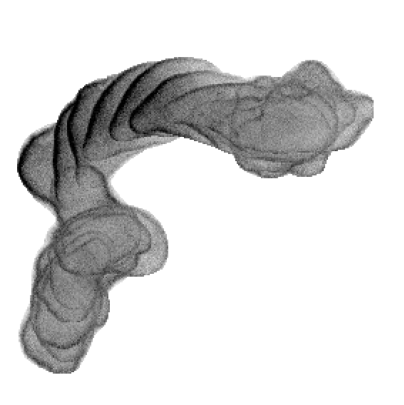

In [633]:
f = glob.glob('../../data/microscopy/Amy/20240213_GalvGFP_1.2mA_10_Single cell example-Cell14/GFP_inverted_jpg/*.jpg')
f=np.sort(f)

frames = np.arange(0,181,10)
# frames = np.arange(0,60,10)
# frames = np.arange(110)

# masked_image = np.zeros_like(im_vel_mask_temp[0])
masked_image = 255*np.ones_like(im_vel_mask_temp[0])

fig, ax = plt.subplots(1, 1, figsize=(5, 5))

for i in frames:
    im_GFP = AICSImage(f[i])  
    im_GFP = im_GFP.get_image_data("YX") 
    im_GFP = im_GFP[:,:]
    im_GFP = im_GFP.astype(np.uint8)
    #im_GFP = 255 - im_GFP

    binary_mask = im_vel_mask_temp[i] 

    binary_mask = scipy.ndimage.binary_dilation(binary_mask, structure=np.ones((3,3)), iterations = 2)
    binary_mask = binary_mask.astype(np.uint8)

    # Apply the mask to the image
    masked_image_ = mask_array(im_GFP,binary_mask)
    #masked_image_ = cv2.bitwise_and(im_GFP, im_GFP, mask=binary_mask)
    
    masked_image = merge_arrays(masked_image, masked_image_)

    
# masked_image[masked_image==0] = 255 
# masked_image = 255- masked_image
ax.imshow(masked_image, cmap='gray')
    
ax.axis('off')

(-0.5, 269.5, 269.5, -0.5)

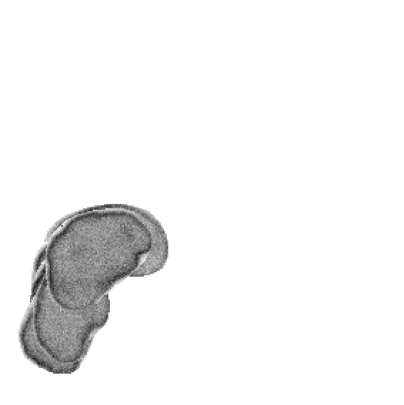

In [561]:
def merge_arrays_2(A, B):
    # Ensure both arrays are numpy arrays
    A = np.array(A)
    B = np.array(B)
    
    # Check if the shapes of A and B are the same
    if A.shape != B.shape:
        raise ValueError("Both arrays must have the same shape")
    
    # Initialize the result array with zeros
    result = np.zeros_like(A)
    
    # Iterate over each element in the arrays
    for i in range(A.shape[0]):
        for j in range(A.shape[1]):
            if A[i, j] == 255 or B[i, j] != 255:
                result[i, j] = B[i, j]
            elif A[i, j] != 255 and B[i, j] != 255:
                result[i, j] = B[i, j]
            else:
                result[i, j] = A[i, j]
    
    return result

f = glob.glob('../../data/microscopy/Amy/20240213_GalvGFP_1.2mA_10_Single cell example-Cell14/GFP_inverted_jpg/*.jpg')
f=np.sort(f)

frames = np.arange(60,120,10)
frames = np.arange(0,60,10)
# frames = np.arange(110)

# masked_image = np.zeros_like(im_vel_mask_temp[0])
masked_image = 255*np.ones_like(im_vel_mask_temp[0])


fig, ax = plt.subplots(1, 1, figsize=(5, 5))

for i in frames:
    im_GFP = AICSImage(f[i])  
    im_GFP = im_GFP.get_image_data("YX") 
    im_GFP = im_GFP[:,:]
    im_GFP = im_GFP.astype(np.uint8)
    #im_GFP = 255 - im_GFP

    binary_mask = im_vel_mask_temp[i] 

    binary_mask = scipy.ndimage.binary_dilation(binary_mask, structure=np.ones((3,3)), iterations = 2)
    binary_mask = binary_mask.astype(np.uint8)

    # Apply the mask to the image
    masked_image_ = mask_array(im_GFP,binary_mask)
    #masked_image_ = cv2.bitwise_and(im_GFP, im_GFP, mask=binary_mask)
    
    masked_image = merge_arrays_2(masked_image, masked_image_)

    
# masked_image[masked_image==0] =255
# masked_image = 255- masked_image
ax.imshow(masked_image, cmap='gray')
    
ax.axis('off')

   

(-0.5, 269.5, 269.5, -0.5)

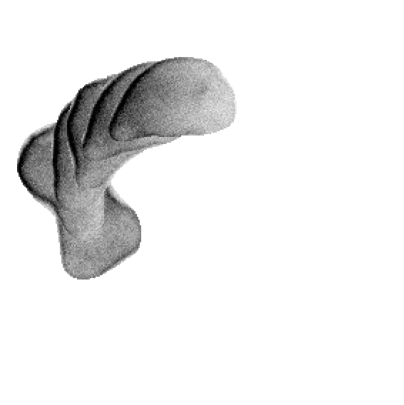

In [562]:

f = glob.glob('../../data/microscopy/Amy/20240213_GalvGFP_1.2mA_10_Single cell example-Cell14/GFP_inverted_jpg/*.jpg')
f=np.sort(f)

frames = np.arange(60,120,10)


# masked_image = np.zeros_like(im_vel_mask_temp[0])
masked_image = 255*np.ones_like(im_vel_mask_temp[0])


fig, ax = plt.subplots(1, 1, figsize=(5, 5))

for i in frames:
    im_GFP = AICSImage(f[i])  
    im_GFP = im_GFP.get_image_data("YX") 
    im_GFP = im_GFP[:,:]
    im_GFP = im_GFP.astype(np.uint8)
    #im_GFP = 255 - im_GFP

    binary_mask = im_vel_mask_temp[i] 

    binary_mask = scipy.ndimage.binary_dilation(binary_mask, structure=np.ones((3,3)), iterations = 2)
    binary_mask = binary_mask.astype(np.uint8)

    # Apply the mask to the image
    masked_image_ = mask_array(im_GFP,binary_mask)
    #masked_image_ = cv2.bitwise_and(im_GFP, im_GFP, mask=binary_mask)
    
    masked_image = merge_arrays_2(masked_image, masked_image_)

    
# masked_image[masked_image==0] =255
# masked_image = 255- masked_image
ax.imshow(masked_image, cmap='gray')
    
ax.axis('off')


(-0.5, 269.5, 269.5, -0.5)

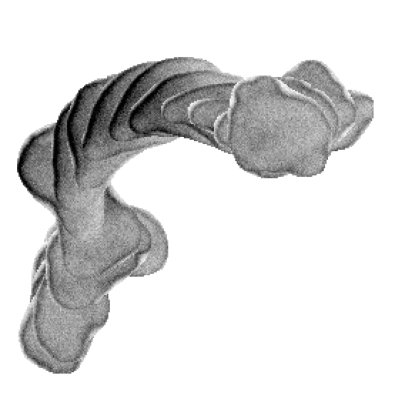

In [631]:

f = glob.glob('../../data/microscopy/Amy/20240213_GalvGFP_1.2mA_10_Single cell example-Cell14/GFP_inverted_jpg/*.jpg')
f=np.sort(f)


frames = np.arange(0,181,10)


# masked_image = np.zeros_like(im_vel_mask_temp[0])
masked_image = 255*np.ones_like(im_vel_mask_temp[0])


fig, ax = plt.subplots(1, 1, figsize=(5, 5))

for i in frames:
    im_GFP = AICSImage(f[i])  
    im_GFP = im_GFP.get_image_data("YX") 
    im_GFP = im_GFP[:,:]
    im_GFP = im_GFP.astype(np.uint8)
    #im_GFP = 255 - im_GFP

    binary_mask = im_vel_mask_temp[i] 

    binary_mask = scipy.ndimage.binary_dilation(binary_mask, structure=np.ones((3,3)), iterations = 2)
    binary_mask = binary_mask.astype(np.uint8)

    # Apply the mask to the image
    masked_image_ = mask_array(im_GFP,binary_mask)
    #masked_image_ = cv2.bitwise_and(im_GFP, im_GFP, mask=binary_mask)
    
    masked_image = merge_arrays_2(masked_image, masked_image_)

    
# masked_image[masked_image==0] =255
# masked_image = 255- masked_image
ax.imshow(masked_image, cmap='gray')
    
ax.axis('off')


In [605]:
im_m_dilate.shape

(270, 270)

In [606]:
f = glob.glob('../../data/microscopy/Amy/20240213_GalvGFP_1.2mA_10_Single cell example-Cell14/*Vel*C1.tif')
# load image 
im_c1 = AICSImage(f[0])  
im_c1 = im_c1.get_image_data("ZYX") 

f = glob.glob('../../data/microscopy/Amy/20240213_GalvGFP_1.2mA_10_Single cell example-Cell14/*Vel*C2.tif')
# load image 
im_c2 = AICSImage(f[0])  
im_c2 = im_c2.get_image_data("ZYX") 


im_vel = im_c1 + im_c2

# # # placeholder for segmentation masks
im_vel_mask = np.zeros_like(im_vel)

# perform segmentation
for t in np.arange(im_vel.shape[0]): #[:1]:
    # gradient of phase image, with threshold cutoff to identify cell boundaries 
    im_temp = im_vel[t]
    im_temp[im_temp>0] = 1
    im_temp = binary_dilation(im_temp, structure = np.ones((2,2)), iterations=1)
    
    im_vel_mask[t] = sp.ndimage.binary_fill_holes(im_temp)
    
    
########## get rid of 'ON'

im_vel_mask_temp = np.zeros_like(im_vel_mask)
im_vel_mask_temp = im_vel_mask_temp[:,:,:]



for i in np.arange(im_vel_mask.shape[0]):
    im_m_temp = im_vel_mask[i,:,:]
    im_m_temp[:50,:70] = 0
    
    im_labeled, n_labels = skimage.measure.label(im_vel_mask[i,:,:], background=0, return_num=True)
    im_labeled[im_labeled != 1] = 0
    im_vel_mask_temp[i] = im_labeled

In [607]:
# f = glob.glob('../../data/microscopy/Amy/20240213_GalvGFP_1.2mA_10_Single cell example-Cell14/*Vel*C1.tif')
# # load image 
# im_c1 = AICSImage(f[0])  
# im_c1 = im_c1.get_image_data("ZYX") 

# f = glob.glob('../../data/microscopy/Amy/20240213_GalvGFP_1.2mA_10_Single cell example-Cell14/*Vel*C2.tif')
# # load image 
# im_c2 = AICSImage(f[0])  
# im_c2 = im_c2.get_image_data("ZYX") 

# im_vel = im_c1.astype(np.float32) - im_c2.astype(np.float32)
# # im_vel = im_vel[0,0,:,:,:]

# # take a look; ignore other cells
# im_vel_ = np.zeros_like(im_vel)

# for t in np.arange(im_vel.shape[0]):
#     im_vel_[t] = np.multiply(im_vel[t], im_m_dilate)

array([60, 65, 70, 75, 80, 85])

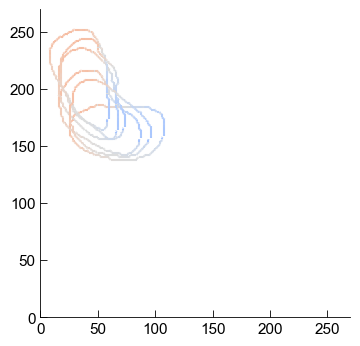

In [610]:
# Create a figure and axis
fig, ax = plt.subplots()
    
    
# frames = np.arange(60,120, 10)
frames = np.arange(0,60, 10)

for count, i in enumerate(frames):

    frame = i
#     cell_val = df_cells[df_cells.frame == frame].cell.values[0]
    #######
    # 1. Identify cell in mask 
    #######
#     im_labeled, n_labels = skimage.measure.label(im_vel_mask[frame,:,:], background=0, return_num=True)

#     df_cells_ = df_cells[df_cells.frame == frame]
#     ind = im_labeled[np.floor(df_cells_[df_cells_.cell == cell_val].centroid.values[0]).astype('int')[0],
#               np.floor(df_cells_[df_cells_.cell == cell_val].centroid.values[0]).astype('int')[1]]

#     # generate mask file with only cell of interest
#     im_labeled[im_labeled != ind] = 0
#     im_labeled[im_labeled>0] = 1
#     im_m = im_labeled
#     im_m = binary_erosion(im_m, structure = np.ones((3,3)), iterations = 3)    
#     im_m = im_m.astype(np.float32)
    
    im_m = im_vel_mask_temp[frame]



    #######
    # 3. Quantify edge intensity
    #######
    # turn mask edge into a line
    new_line = polygon_to_line(im_m)
    new_line_length_pixels = new_line.length
    # quantify intensity along line (Note that the following 
    # function also performs a background subtraction using the average pixel
    # intensity in [x, y] region = [0:10,0:10])
    vals, x, y, xy = cell_contour_intensity_max2(new_line,im_vel[frame].T, cd_length = 15) 

    # Convert to real micron units 
    # Since I split the edge into 300 posiitons, 
    # need to convert to pixels and then to micron.
    # x = np.arange(len(vals))*(new_line_length_pixels/300)/(995/210)


    # #######
    # # 4. Take a look at values
    # #######

    # # Create a figure
    # fig = plt.figure(figsize=(8, 4), tight_layout=True)

    # # Define a GridSpec with the desired width ratios
    # gs = GridSpec(1, 2, width_ratios=[2, 1], figure=fig)

    # # Create subplots
    # ax1 = fig.add_subplot(gs[0])

    # ax3 = fig.add_subplot(gs[1])

    # ax1.plot(x, vals, 'ro',alpha = 0.4)
    # ax1.set_ylabel('fluorescence\nintensity (a.u.)')
    # ax1.set_xlabel(r'position along cell edge ($\mu$m)')


    # ax3.imshow(im_vel[0])

    # # Find contours
    # contours = measure.find_contours(im_m, level=0.5)

    # # Plot each contour
    # for contour in contours:
    #     ax3.plot(contour[:, 1], contour[:, 0], linewidth=2, color='red')

    xy = xy.reshape((300,2))

    # Normalize the values for coloring
    #norm = Normalize(vmin=values.min(), vmax=values.max())
    norm = Normalize(vmin=-255, vmax=255)
    cmap = cm.coolwarm.reversed()

    # Create line segments
    points = xy.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    # Create a LineCollection
    lc = LineCollection(segments, cmap=cmap, norm=norm)
    lc.set_array(values)
    lc.set_linewidth(1.5)

    # Add the LineCollection to the plot
    ax.add_collection(lc)

    # Set plot limits
    # ax.set_xlim(xy[:, 0].min() - 1, xy[:, 0].max() + 1)
    # ax.set_ylim(xy[:, 1].min() - 1, xy[:, 1].max() + 1)
    ax.set_xlim(0,270)
    ax.set_ylim(0,270)



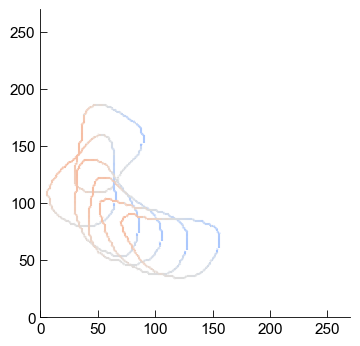

In [611]:
# Create a figure and axis
fig, ax = plt.subplots()
    
    
frames = np.arange(60,120, 10)
# frames = np.arange(0,60, 10)

for count, i in enumerate(frames):

    frame = i    
    im_m = im_vel_mask_temp[frame]

    #######
    # 3. Quantify edge intensity
    #######
    # turn mask edge into a line
    new_line = polygon_to_line(im_m)
    new_line_length_pixels = new_line.length
    # quantify intensity along line (Note that the following 
    # function also performs a background subtraction using the average pixel
    # intensity in [x, y] region = [0:10,0:10])
    vals, x, y, xy = cell_contour_intensity_max2(new_line,im_vel[frame].T, cd_length = 15) 

    xy = xy.reshape((300,2))

    # Normalize the values for coloring
    #norm = Normalize(vmin=values.min(), vmax=values.max())
    norm = Normalize(vmin=-255, vmax=255)
    cmap = cm.coolwarm.reversed()

    # Create line segments
    points = xy.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    # Create a LineCollection
    lc = LineCollection(segments, cmap=cmap, norm=norm)
    lc.set_array(values)
    lc.set_linewidth(1.5)

    # Add the LineCollection to the plot
    ax.add_collection(lc)

    # Set plot limits
    # ax.set_xlim(xy[:, 0].min() - 1, xy[:, 0].max() + 1)
    # ax.set_ylim(xy[:, 1].min() - 1, xy[:, 1].max() + 1)
    ax.set_xlim(0,270)
    ax.set_ylim(0,270)


(0.0, 270.0)

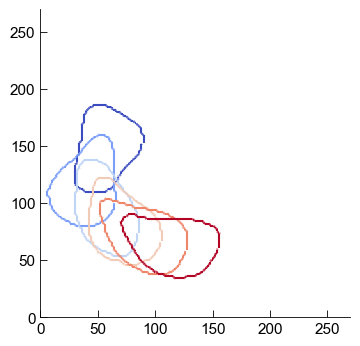

In [628]:
# Define a function to generate a colormap transitioning from blue to red
def create_colormap():
    cdict = {
        'red':   ((0.0, 0.0, 0.0),
                  (1.0, 1.0, 1.0)),
        'green': ((0.0, 0.0, 0.0),
                  (1.0, 0.0, 0.0)),
        'blue':  ((0.0, 1.0, 1.0),
                  (1.0, 0.0, 0.0))
    }
    return LinearSegmentedColormap('BlueRed', cdict)


fig, ax = plt.subplots()

frames = np.arange(60, 120, 10)
num_frames = len(frames)
cmap = cm.get_cmap('coolwarm', num_frames)

for count, frame in enumerate(frames):  
    im_m = im_vel_mask_temp[frame]

    #######
    # 3. Quantify edge intensity
    #######
    # turn mask edge into a line
    new_line = polygon_to_line(im_m)
    new_line_length_pixels = new_line.length
    # quantify intensity along line (Note that the following 
    # function also performs a background subtraction using the average pixel
    # intensity in [x, y] region = [0:10,0:10])
    _, x, y, xy = cell_contour_intensity_max2(new_line, im_vel[frame].T, cd_length=15) 

    xy = xy.reshape((300, 2))
    
    # Normalize the values for coloring
    norm = Normalize(vmin=frames.min(), vmax=frames.max())

    # Create line segments
    points = xy.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    # Create a LineCollection
    lc = LineCollection(segments, cmap=cmap, norm=norm)
    lc.set_array(np.full(300, frame))  # Use the frame values for coloring
    lc.set_linewidth(1.5)

    # Add the LineCollection to the plot
    ax.add_collection(lc)

# Set plot limits
ax.set_xlim(0, 270)
ax.set_ylim(0, 270)

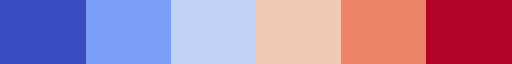

In [627]:
cmap

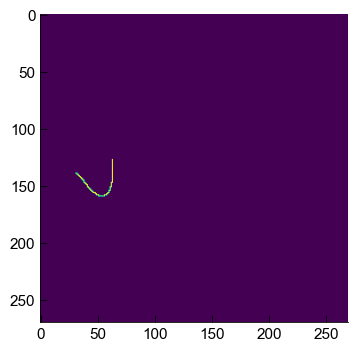

In [604]:
plt.imshow(im_vel_[70])

In [391]:
#  df_cells[df_cells.frame == 60]
    
im_labeled, n_labels = skimage.measure.label(im_vel_mask[60,:,:], background=0, return_num=True)

df_cells_ = df_cells[df_cells.frame == 60]
ind = im_labeled[np.floor(df_cells_[df_cells_.cell == cell_val].centroid.values[0]).astype('int')[0],
          np.floor(df_cells_[df_cells_.cell == cell_val].centroid.values[0]).astype('int')[1]]

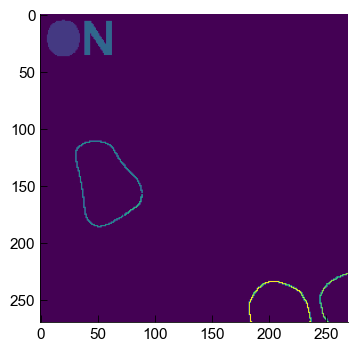

In [393]:
plt.imshow(im_labeled)

In [381]:
xy

array([[ 82.        ,  72.        ],
       [ 82.        ,  72.76051443],
       [ 82.        ,  73.52102886],
       [ 82.        ,  74.28154329],
       [ 82.        ,  75.04205772],
       [ 82.        ,  75.80257215],
       [ 82.        ,  76.56308658],
       [ 82.        ,  77.32360101],
       [ 82.        ,  78.08411544],
       [ 82.        ,  78.84462987],
       [ 82.        ,  79.6051443 ],
       [ 82.        ,  80.36565873],
       [ 82.        ,  81.12617316],
       [ 82.        ,  81.88668759],
       [ 82.        ,  82.64720202],
       [ 82.        ,  83.40771645],
       [ 82.        ,  84.16823088],
       [ 82.        ,  84.92874531],
       [ 82.        ,  85.68925974],
       [ 82.        ,  86.44977417],
       [ 81.85130351,  87.14869649],
       [ 81.3135386 ,  87.6864614 ],
       [ 80.68289611,  88.        ],
       [ 80.        ,  88.07761832],
       [ 80.        ,  88.83813275],
       [ 80.        ,  89.59864718],
       [ 80.        ,  90.35916161],
 

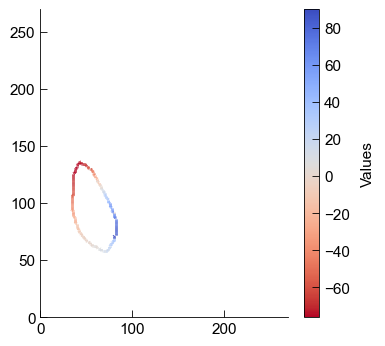

In [339]:
points

array([[[array([167.        , 106.        , 167.71946873, 106.        ,
                168.        , 105.56106253, 168.1120101 , 104.8879899 ,
                168.62075132, 104.37924868, 169.18313011, 104.        ,
                169.90259885, 104.        , 170.62206758, 104.        ,
                171.34153632, 104.        , 172.06100505, 104.        ,
                172.78047379, 104.        , 173.35351275, 103.64648725,
                173.86225397, 103.13774603, 174.        , 102.47533357,
                174.24413516, 102.        , 174.9636039 , 102.        ,
                175.68307263, 102.        , 176.        , 101.59745863,
                176.        , 100.8779899 , 176.        , 100.15852116,
                176.56094757, 100.        , 177.19828427,  99.80171573,
                177.70702549,  99.29297451, 178.        ,  98.69485979,
                178.        ,  97.97539105, 178.        ,  97.25592232,
                178.        ,  96.53645358, 178.18301515,  96.  

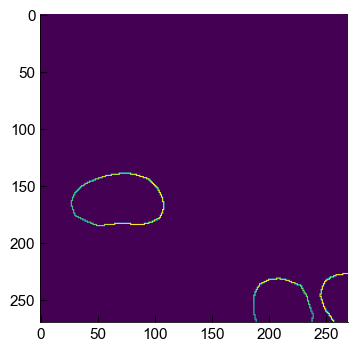

In [106]:
plt.imshow(img[0,:,:])

In [ ]:
# Take a look at all frames (last 15 frames of EF on)

frames = np.arange(75,90)

for count, i in enumerate(frames):
    #######
    # 1. Identify cell in mask 
    #######

    im_labeled, n_labels = skimage.measure.label(im_mask[i,:,:], background=0, return_num=True)
    
    ind = im_labeled[np.floor(df_cells[df_cells.cell == cell_val].centroid.values[0]).astype('int')[0],
          np.floor(df_cells[df_cells.cell == cell_val].centroid.values[0]).astype('int')[1]]

    im_labeled[im_labeled != ind] = 0
    im_labeled[im_labeled>0] = 1

    im_m = im_labeled
    
    #######
    # 2. Crop region of interest with some padding around cell (for both intensity image and mask)
    #######
    rows, cols = np.where(im_labeled == 1)
    pad = 50
    min_row, max_row = np.max([0,np.min(rows)-pad]), np.min([1024, np.max(rows)+pad])
    min_col, max_col = np.max([0,np.min(cols)-pad]), np.min([1024, np.max(cols)+pad])
    
    im_temp = im_gfp[i,min_row:max_row,min_col:max_col]
    im_m = im_m[min_row:max_row,min_col:max_col]
    
    #######
    # 3. Quantify edge intensity
    #######
    # turn mask edge into a line
    new_line = polygon_to_line(im_m)
    new_line_length_pixels = new_line.length
    # quantify intensity along line (Note that the following 
    # function also performs a background subtraction using the average pixel
    # intensity in [x, y] region = [0:10,0:10])
    vals = cell_contour_intensity_max(new_line,im_temp.T, cd_length = 10) 

    # Convert to real micron units 
    # Since I split the edge into 300 posiitons, 
    # need to convert to pixels and then to micron.
    x = np.arange(len(vals))*(new_line_length_pixels/300)/(995/210)

    # for simplicity in fitting, lets shift the x dimension so that
    # the peak is centered. 
    ind = np.argmax(vals)
    vals = np.roll(vals, 150-ind)
    
    # Renormalize the fluorescence values from 1 to 0
    # Assume under this condition, cathode side is nearly void of protein 
    vals_zeroed = vals_zeroed = (vals - np.mean(vals[290:]))
    vals_renorm = vals_zeroed/ np.max(vals_zeroed)
    

    #######
    # 4. Take a look at values
    #######
    
    # Create a figure
    fig = plt.figure(figsize=(12, 4), tight_layout=True)

    # Define a GridSpec with the desired width ratios
    gs = GridSpec(1, 3, width_ratios=[3, 3, 1], figure=fig)

    # Create subplots
    ax1 = fig.add_subplot(gs[0])
    ax2 = fig.add_subplot(gs[1])
    ax3 = fig.add_subplot(gs[2])

    ax1.plot(x, vals_renorm, 'ro',alpha = 0.4)
    ax1.set_ylabel('fluorescence\nintensity (a.u.)')
    ax1.set_xlabel(r'position along cell edge ($\mu$m)')
    
    ax2.plot(x, vals_renorm, 'ro',alpha = 0.4)
    ax2.set_ylabel('fluorescence\nintensity (a.u.)')
    ax2.set_xlabel(r'position along cell edge ($\mu$m)')
    ax2.set_yscale('log')
    ax2.set_ylim(0.001,1.1)

    ax3.imshow(im_temp)

    # Find contours
    contours = measure.find_contours(im_m, level=0.5)

    # Plot each contour
    for contour in contours:
        ax3.plot(contour[:, 1], contour[:, 0], linewidth=2, color='red')


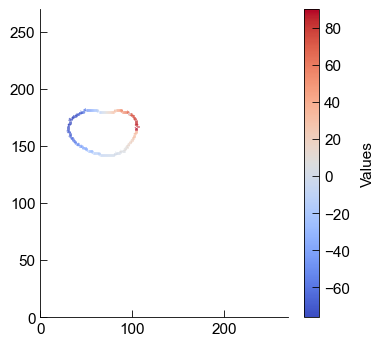

/var/folders/hs/8f67z23n6g9g9g4y03yhrn_c0000gn/T/ipykernel_35132/1210922352.py:29: UserWarning: The following kwargs were not used by contour: 'label'
  contour = ax.contour(img_[t], levels=10, cmap=cmap, norm=norm, alpha=0.5, label=f'Time {t}')
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


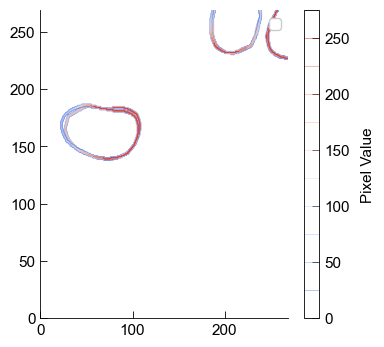

In [108]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import matplotlib.cm as cm

# # Read the .tif file
# file_path = f
# with rasterio.open(file_path) as src:
#     img = src.read()  # Read all bands (time series)

# img.shape should be (time, height, width)
img_ = np.zeros_like(img)
for t in np.arange(img.shape[0]):
    img_[t] = sp.ndimage.binary_erosion(img[t], structure = np.ones((1,1)), iterations=20)
    
img_ = np.multiply(img_, img)
# Normalize pixel values for coloring
# norm = Normalize(vmin=img.min(), vmax=img.max())
norm = Normalize(vmin=np.min(np.unique(img)[1:]), vmax=np.max(np.unique(img)[1:]))
cmap = cm.coolwarm

# Create a figure and axis
fig, ax = plt.subplots()

# Plot the contours for each time step
time_steps = 2# img.shape[0]
for t in range(time_steps):
    contour = ax.contour(img_[t], levels=10, cmap=cmap, norm=norm, alpha=0.5, label=f'Time {t}')

# Add a color bar
fig.colorbar(contour, ax=ax, orientation='vertical', label='Pixel Value')

# Add legend
ax.legend()

# Show the plot
plt.show()

In [361]:
f

['../../data/microscopy/Amy/20240213_GalvGFP_1.2mA_10_Single cell example-Cell14/cell14_Velocity_Visualisation_C2.tif',
 '../../data/microscopy/Amy/20240213_GalvGFP_1.2mA_10_Single cell example-Cell14/cell14_Velocity_Visualisation_C1.tif',
 '../../data/microscopy/Amy/20240213_GalvGFP_1.2mA_10_Single cell example-Cell14/cell14_Velocity_Visualisation.tif']

In [362]:
f = glob.glob('../../data/microscopy/Amy/20240213_GalvGFP_1.2mA_10_Single cell example-Cell14/*Vel*.tif')
# load image 
im_vel__ = AICSImage(f[-1])  
im_vel__ = im_vel__.get_image_data("ZYX") 
im_vel__.shape

(181, 270, 270)

ValueError: cannot convert float NaN to integer

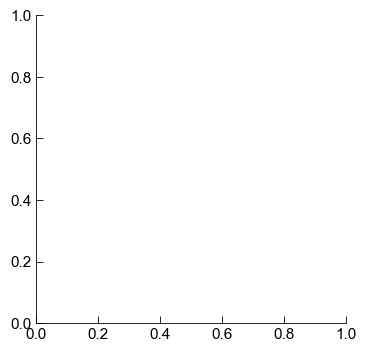

In [364]:
from matplotlib.colors import BoundaryNorm


# img.shape should be (time, height, width)

# Define discrete colormap
cmap = cm.coolwarm
levels = np.arange(1, im_vel__.max() + 1, 1)
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

# Create a figure and axis
fig, ax = plt.subplots()

# Plot the image for each time step
time_steps = 2 #img.shape[0]
for t in range(time_steps):
    # Mask the background (where value = 0)
    #masked_img = np.ma.masked_where(img[t] == 1, img[t])
    im_ = im_vel__[t]
    im_[im_ == 0.0] = np.nan
    ax.imshow(im_, cmap=cmap, norm=norm, alpha=0.5)

# Add a color bar
cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, orientation='vertical', 
                    label='Pixel Value')


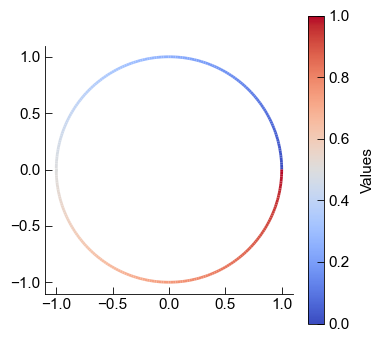

In [122]:
img.min()

# Start over using new data


In [6]:
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.collections import LineCollection, PolyCollection
import matplotlib.cm as cm
import numpy as np
import glob
import pandas as pd

import scipy

import skimage
from skimage import measure
from skimage import exposure

from aicsimageio import AICSImage
from aicsimageio.writers import OmeTiffWriter

plt.style.use('styleNB.mplstyle')

## Galvanin-GFP signal

In [4]:
# define a function to generate an overlay of the signals across different frames

def merge_arrays_r(A, B):
    # Ensure both arrays are numpy arrays
    A = np.array(A)
    B = np.array(B)
    
    # Check if the shapes of A and B are the same
    if A.shape != B.shape:
        raise ValueError("Both arrays must have the same shape")
    
    # Initialize the result array with zeros
    #result = np.zeros_like(A)
    # Initialize the result array with zeros
    result = np.ones_like(A)
    
    # Iterate over each element in the arrays
    for i in range(A.shape[0]):
        for j in range(A.shape[1]):
            if A[i, j] != 1 or B[i, j] != 1:
                result[i, j] = max(A[i, j], B[i, j])
    return result


def mask_array_r(A, B):
    #A is real image, B is mask
    # Ensure both arrays are numpy arrays
    A = np.array(A)
    B = np.array(B)
    
    # Check if the shapes of A and B are the same
    if A.shape != B.shape:
        raise ValueError("Both arrays must have the same shape")
    
    # Initialize the result array with zeros
    #result = np.zeros_like(A)
    # Initialize the result array with zeros
    result = A
    
    # Iterate over each element in the arrays
    for i in range(A.shape[0]):
        for j in range(A.shape[1]):
            if B[i, j] == 0:
                result[i, j] = 1
                
    return result


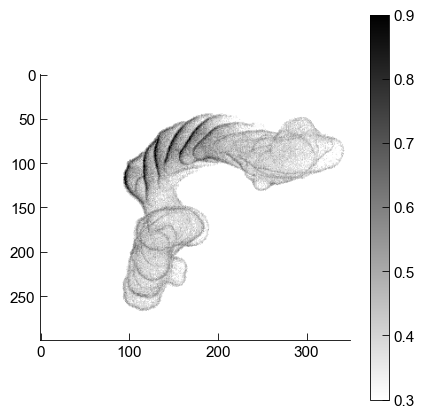

In [5]:
# Load in image data
f = '../../../../../../Volumes/ExpansionHomesA/Amy/Galvanin_data/Kymographs/Data analysis/20240213_dHL60_GalvGFP_AnalysisNew/20240213_GalvGFP_1.2mA_10/channel_1.tif'
im_gfp_ = AICSImage(f) 
im_gfp_ = im_gfp_.get_image_data("ZYX") 

# frames to consider
frames = np.arange(2,181,10)
masked_image = np.ones_like(im_mask[0].T)

# Plot
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

for i in frames:
    im_gfp = im_gfp_[i,150:500,550:850]
    
    im_gfp = im_gfp.astype(np.uint8)
    #im_gfp = 255 - im_gfp

    binary_mask = im_mask[i]

    binary_mask = scipy.ndimage.binary_dilation(binary_mask, structure=np.ones((3,3)), iterations = 2)
    binary_mask = binary_mask.astype(np.uint8)

    masked_image_ = mask_array_r(im_gfp.T, binary_mask.T)
    
    masked_image = merge_arrays_r(masked_image, masked_image_)

masked_image_rescale = exposure.rescale_intensity(masked_image, in_range='image', out_range=(0, 1))

im = ax.imshow(masked_image_rescale[:, ::-1], cmap='gray_r', vmin=0.3, vmax=0.9)

# ax.axis('off')

# Set equal scaling
ax.set_aspect('equal', 'box')

# Add a colorbar
cbar = fig.colorbar(im, ax=ax, orientation='vertical')

# cbar.set_ticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7])
# cbar.set_ticklabels(['0.7', '0.6', '0.5', '0.4', '0.3', '0.2', '0.1', '0'])

# fig.savefig('../../figures/20240805_fig4_example_gfp.pdf')

## Protrusion/retraction speed values

In [8]:
# load in data
dirname = '../../../../../../Volumes/ExpansionHomesA/Amy/Galvanin_data/Kymographs/Data analysis/20240213_dHL60_GalvGFP_AnalysisNew/20240213_GalvGFP_1.2mA_10/Adapt_v1.111_Output/Output_9/'
df_pos = pd.read_csv(dirname + 'cell_boundary_points.csv', skiprows=2, header=None)
df_pos.columns = ['X_pos', 'Y_pos', 'frame']

vel_arr = AICSImage(dirname + '20240213_10_cell9_VelocityMap.tif') 
vel_arr = vel_arr.get_image_data("ZYX") 
vel_arr = vel_arr[0,:,:]

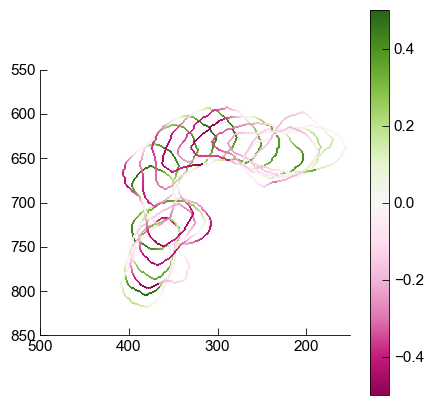

In [11]:
f, ax = plt.subplots(1,1, figsize = (5,5))

# frames to consider
frames = np.arange(2,181,10)

for frame in frames:
    d = df_pos[df_pos.frame == frame]
    
    points = d[['Y_pos', 'X_pos']].values
    
    # Values corresponding to each point
    values = vel_arr[:,frame] 
    # Create line segments from points
    segments = np.array([points[:-1], points[1:]]).transpose(1, 0, 2)

    # Create a LineCollection from the segments
    lc = LineCollection(segments, cmap='PiYG', norm=plt.Normalize(-0.5, 0.5))
    lc.set_array(values)
    lc.set_linewidth(1.5)
    
    # Add the LineCollection to the plot
    ax.add_collection(lc)

ax.set_ylim(550,850)
ax.set_xlim(150,500)


# # Invert the y-axis
ax.invert_yaxis()
ax.invert_xaxis()

# Remove axis lines, labels, and ticks
# ax.axis('off')

# Add a colorbar
norm = plt.Normalize(-0.5,0.5)
sm = plt.cm.ScalarMappable(cmap='PiYG', norm=norm)
sm.set_array([])  # Set empty array for ScalarMappable

# Add the colorbar to the figure, not the axis
cbar = f.colorbar(sm, ax=ax, orientation='vertical')

# Set equal scaling
ax.set_aspect('equal', 'box')

# f.savefig('../../figures/20240805_fig4_example_vel.pdf')

## Time (based on above masks)

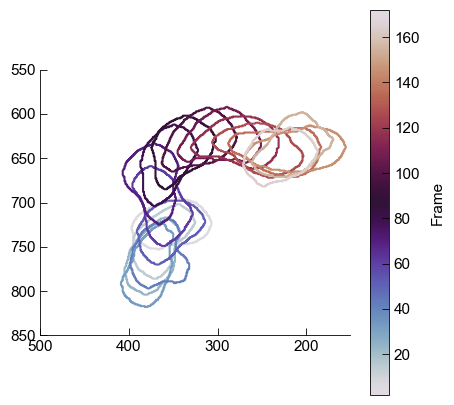

In [12]:
f, ax = plt.subplots(1,1, figsize = (5,5))

# frames to consider
frames = np.arange(2,181,10)

# Define the colormap
cmap = cm.get_cmap('twilight', im_mask.shape[0])  # 'viridis' is an example colormap

for frame in frames:
    d = df_pos[df_pos.frame == frame]
    
    # Separate the x and y coordinates
    x = d['Y_pos'].values #points[:, 0]
    y = d['X_pos'].values
    
    color = cmap(frame / im_mask.shape[0])
    plt.plot(x, y, linestyle='-', color=color, linewidth=1.5)

ax.set_ylim(550,850)
ax.set_xlim(150,500)

# Invert the y-axis
ax.invert_xaxis()
ax.invert_yaxis()

# Remove axis lines, labels, and ticks
# ax.axis('off')

# Add a colorbar
norm = plt.Normalize(frames.min(), frames.max())
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Set empty array for ScalarMappable

# Add the colorbar to the figure, not the axis
cbar = f.colorbar(sm, ax=ax, orientation='vertical')
cbar.set_label('Frame')

# Set equal scaling
ax.set_aspect('equal', 'box')

# f.savefig('../../figures/20240805_fig4_example_time.pdf')